In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array  # These were missing
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [5]:

import os
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def load_and_preprocess_data(directory):
    images = []
    labels = []
    
    for label_idx, emotion in enumerate(emotion_labels):
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            for img_file in os.listdir(emotion_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(emotion_path, img_file)
                    # Load image in grayscale mode and resize to 48x48
                    img = load_img(img_path, color_mode='grayscale', target_size=(48, 48))
                    # Convert to array and normalize
                    img_array = img_to_array(img)
                    img_array = img_array / 255.0
                    
                    images.append(img_array)
                    labels.append(label_idx)
    
    return np.array(images), np.array(labels)

# Load test data
X_test, y_test = load_and_preprocess_data('test')
print(f"Test data shape: {X_test.shape}")

Test data shape: (7178, 48, 48, 1)



Training Dataset Statistics:
--------------------------------------------------
Total number of images: 28709
Image dimensions: (48, 48)
Number of classes: 7

Class Distribution:


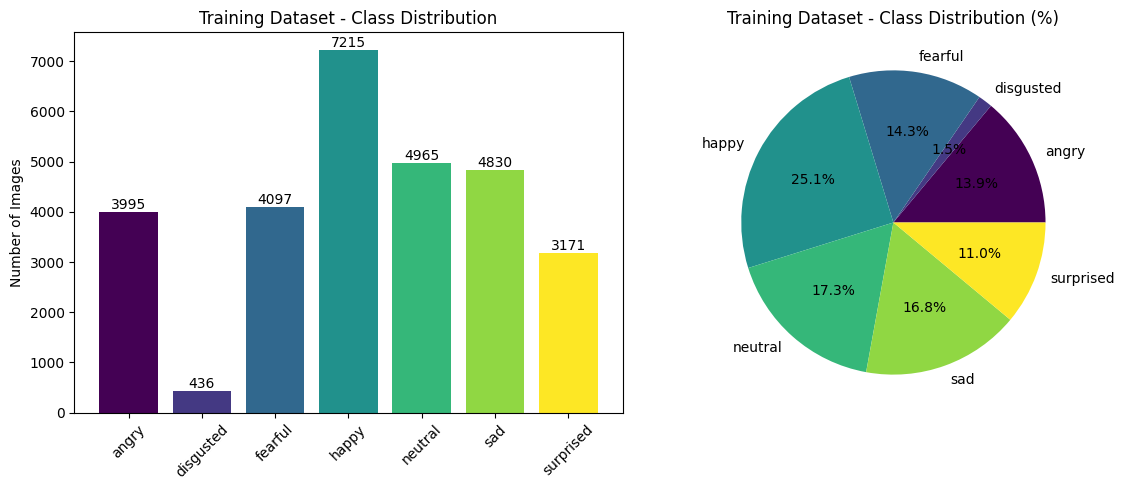


Class-wise Details:
--------------------------------------------------
angry: 3995 images (13.9%)
disgusted: 436 images (1.5%)
fearful: 4097 images (14.3%)
happy: 7215 images (25.1%)
neutral: 4965 images (17.3%)
sad: 4830 images (16.8%)
surprised: 3171 images (11.0%)

Test Dataset Statistics:
--------------------------------------------------
Total number of images: 7178
Image dimensions: (48, 48)
Number of classes: 7

Class Distribution:


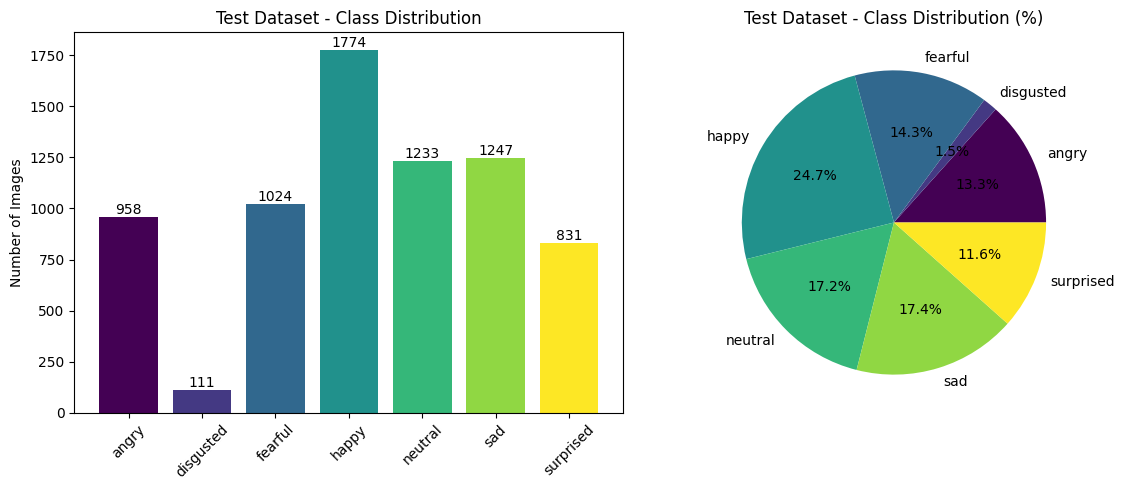


Class-wise Details:
--------------------------------------------------
angry: 958 images (13.3%)
disgusted: 111 images (1.5%)
fearful: 1024 images (14.3%)
happy: 1774 images (24.7%)
neutral: 1233 images (17.2%)
sad: 1247 images (17.4%)
surprised: 831 images (11.6%)


In [6]:
def describe_dataset(directory, title="Dataset"):
    total_images = 0
    class_distribution = {}
    sample_image_shape = None
    
    # Analyze each emotion class
    for emotion in emotion_labels:
        path = os.path.join(directory, emotion)
        if os.path.exists(path):
            # Count images in this class
            images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            class_distribution[emotion] = num_images
            total_images += num_images
            
            # Get sample image shape if we haven't yet
            if sample_image_shape is None and num_images > 0:
                sample_img = load_img(os.path.join(path, images[0]), color_mode='grayscale')
                sample_image_shape = sample_img.size
    
    # Print dataset statistics
    print(f"\n{title} Statistics:")
    print("-" * 50)
    print(f"Total number of images: {total_images}")
    print(f"Image dimensions: {sample_image_shape}")
    print(f"Number of classes: {len(emotion_labels)}")
    print("\nClass Distribution:")
    
    # Plot class distribution
    plt.figure(figsize=(12, 5))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(emotion_labels)))
    bars = plt.bar(class_distribution.keys(), class_distribution.values(), color=colors)
    plt.xticks(rotation=45)
    plt.title(f'{title} - Class Distribution')
    plt.ylabel('Number of Images')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(class_distribution.values(), labels=class_distribution.keys(),
            autopct='%1.1f%%', colors=colors)
    plt.title(f'{title} - Class Distribution (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Print class-wise statistics
    print("\nClass-wise Details:")
    print("-" * 50)
    for emotion, count in class_distribution.items():
        percentage = (count / total_images) * 100
        print(f"{emotion}: {count} images ({percentage:.1f}%)")

# Analyze both training and test sets
describe_dataset('train', "Training Dataset")
describe_dataset('test', "Test Dataset")

In [22]:
# Load the model
model = load_model('emotion.keras', compile=False)

# Get model summary
print("Model Layers")
model.summary()

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Model Layers


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step


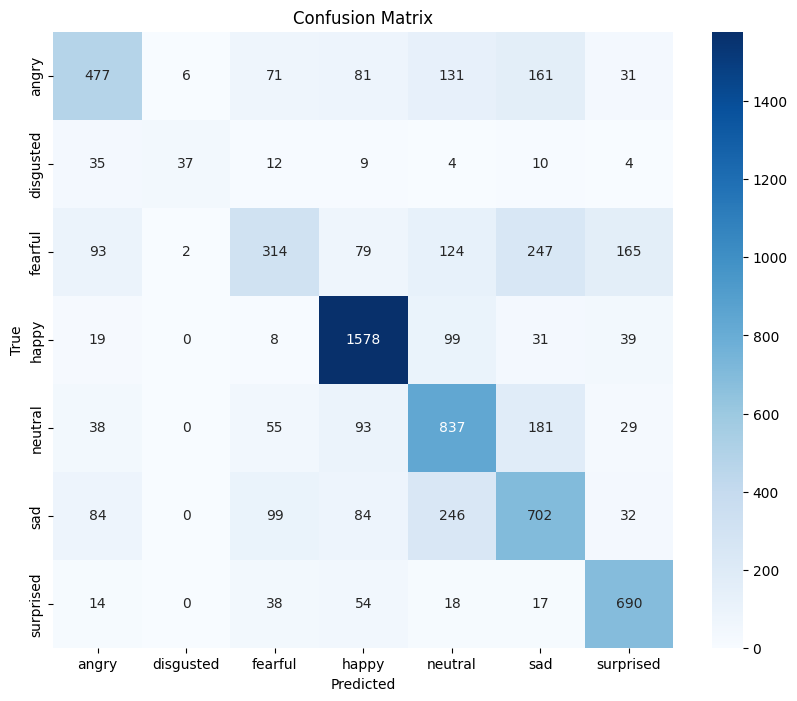

In [8]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))


Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.50      0.56       958
   disgusted       0.82      0.33      0.47       111
     fearful       0.53      0.31      0.39      1024
       happy       0.80      0.89      0.84      1774
     neutral       0.57      0.68      0.62      1233
         sad       0.52      0.56      0.54      1247
   surprised       0.70      0.83      0.76       831

    accuracy                           0.65      7178
   macro avg       0.65      0.59      0.60      7178
weighted avg       0.64      0.65      0.63      7178



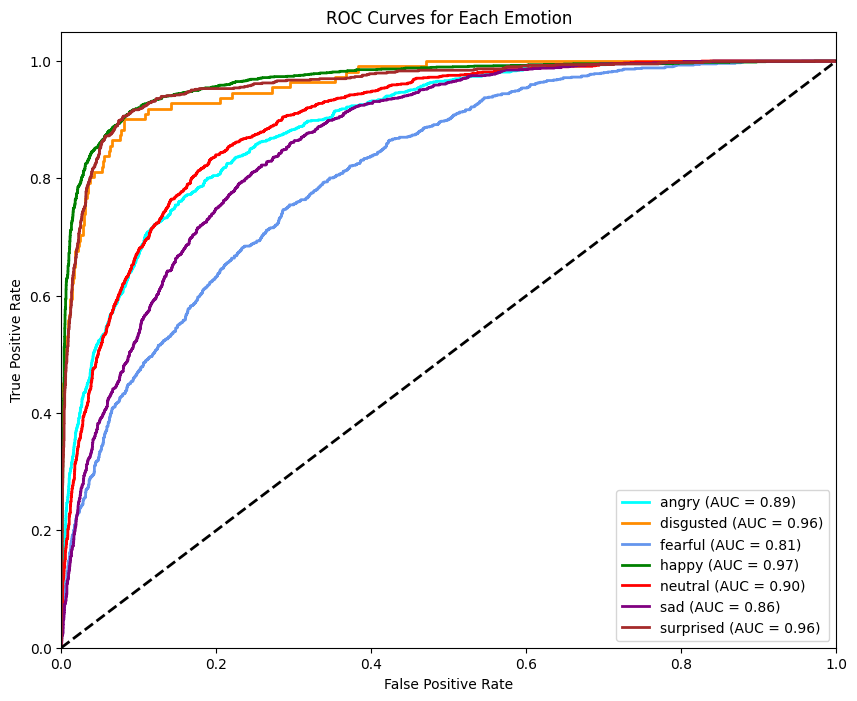

In [10]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Plot ROC curves for each emotion
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

for i, color in zip(range(len(emotion_labels)), colors):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_test)[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{emotion_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Emotion')
plt.legend(loc="lower right")
plt.show()


Overall Model Metrics:


,Score
Accuracy,0.6457
Precision,0.6383
Recall,0.6457
F1 Score,0.6331


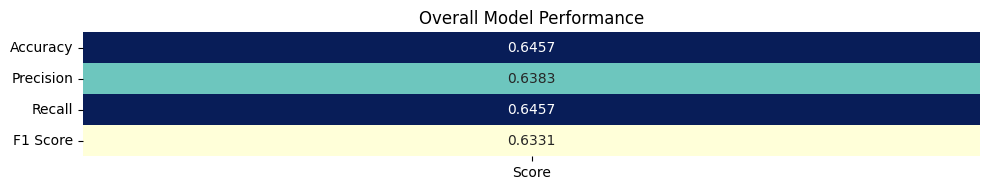

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_classes),
    'Precision': precision_score(y_test, y_pred_classes, average='weighted'),
    'Recall': recall_score(y_test, y_pred_classes, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_classes, average='weighted')
}

# Create metrics DataFrame
metrics_df = pd.DataFrame([metrics])
metrics_df = metrics_df.T
metrics_df.columns = ['Score']
metrics_df['Score'] = metrics_df['Score'].round(4)

# Display table
print("\nOverall Model Metrics:")
display(metrics_df)

# Create heatmap visualization
plt.figure(figsize=(10, 2))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.4f', cbar=False)
plt.title('Overall Model Performance')
plt.tight_layout()
plt.show()


Class-wise Performance Metrics:


,Precision,Recall,F1 Score
Emotion,,,
angry,0.6276,0.4979,0.5553
disgusted,0.8222,0.3333,0.4744
fearful,0.5260,0.3066,0.3874
happy,0.7978,0.8895,0.8412
neutral,0.5737,0.6788,0.6218
sad,0.5204,0.5630,0.5408
surprised,0.6970,0.8303,0.7578


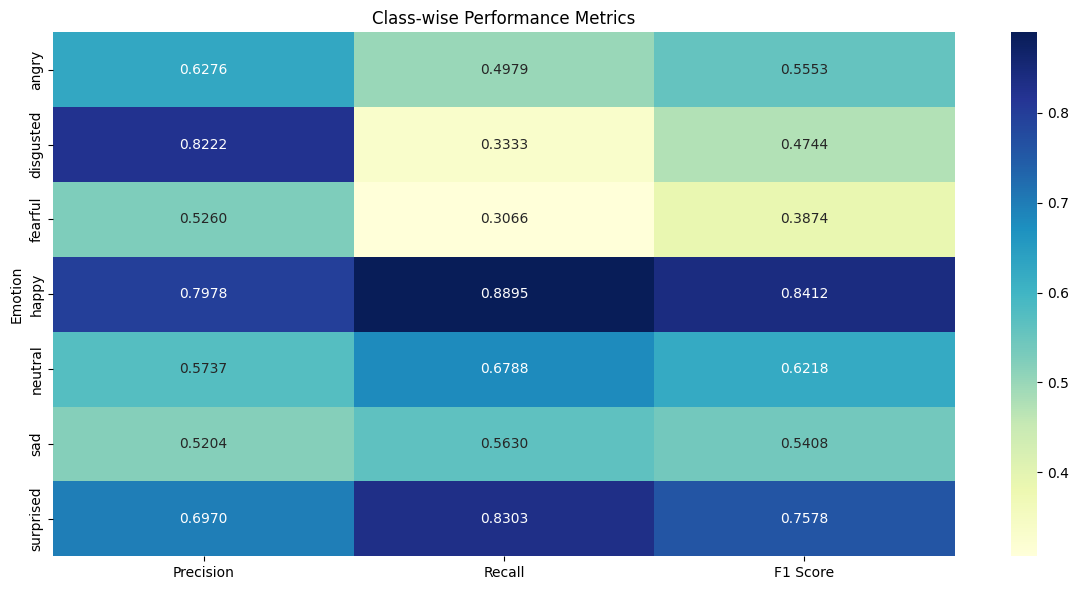

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Calculate metrics for each class
class_metrics = []
for i, emotion in enumerate(emotion_labels):
    metrics = {
        'Emotion': emotion,
        'Precision': precision_score(y_test, y_pred_classes, labels=[i], average='micro'),
        'Recall': recall_score(y_test, y_pred_classes, labels=[i], average='micro'),
        'F1 Score': f1_score(y_test, y_pred_classes, labels=[i], average='micro')
    }
    class_metrics.append(metrics)

# Create and display metrics table
metrics_df = pd.DataFrame(class_metrics)
metrics_df.set_index('Emotion', inplace=True)
metrics_df = metrics_df.round(4)

print("\nClass-wise Performance Metrics:")
display(metrics_df)

# Optional: Add a heatmap for visual representation
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('Class-wise Performance Metrics')
plt.tight_layout()
plt.show()

In [17]:
pip install graphviz pydot


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
def visualize_model_layers(model):
    print("Model Architecture Visualization")
    print("=" * 50)
    
    # Calculate the maximum length for formatting
    max_name_len = max(len(layer.name) for layer in model.layers)
    max_type_len = max(len(layer.__class__.__name__) for layer in model.layers)
    
    # Print header
    print(f"{'Layer Name':<{max_name_len}} | {'Type':<{max_type_len}} | Input Shape | Output Shape | Parameters")
    print("-" * (max_name_len + max_type_len + 50))
    
    # Print each layer
    for layer in model.layers:
        # Get layer details
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        input_shape = str(layer.input_shape)
        output_shape = str(layer.output_shape)
        
        # Calculate parameters
        params = layer.count_params()
        
        # Print formatted line
        print(f"{layer_name:<{max_name_len}} | {layer_type:<{max_type_len}} | {input_shape:<12} | {output_shape:<13} | {params:,}")

# Visualize the model
visualize_model_layers(model)

Model Architecture Visualization
Layer Name            | Type               | Input Shape | Output Shape | Parameters
-----------------------------------------------------------------------------------------


AttributeError: 'Conv2D' object has no attribute 'input_shape'

In [25]:
pip install jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
def save_model_table_as_image(model, filename='model_architecture.png'):
    # Create a list of dictionaries for each layer
    layers_data = []
    cell_colors = []
    for layer in model.layers:
        layer_info = {
            'Layer Name': layer.name,
            'Type': layer.__class__.__name__,
            'Output Shape': str(layer.output.shape),  # Changed from output_shape to output.shape
            'Parameters': f"{layer.count_params():,}"
        }
        layers_data.append(layer_info)

    
    # Create DataFrame
    df = pd.DataFrame(layers_data)
    
    # Create figure and table
    fig, ax = plt.subplots(figsize=(15, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table with colors
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    cellLoc='left',
                    loc='center')

    # Add title
    plt.title('Model Architecture', pad=20, fontsize=14)
    
    # Save the figure
    plt.savefig(filename, dpi=300)
    plt.close()
    
    print(f"Model architecture saved as {filename}")

# Save the model table as an image with colors
save_model_table_as_image(model, 'model_architecture_colored.png')

Model architecture saved as model_architecture_colored.png
